# Denoising Autoencoder on MNIST (PyTorch) + PCA and t-SNE Latent Visualizations

This notebook implements a **denoising autoencoder** trained on MNIST.  
It also visualizes the **latent space** (encoder output) using **PCA** and **t-SNE**, and shows how the **decoder** maps latent codes back to images.

**Denoising objective:** feed a *noisy* input $\tilde{x}$ but reconstruct the *clean* target $x$:

$\min_\theta \; \mathbb{E}\left[\mathcal{L}\big(f_\theta(\tilde{x}),\; x\big)\right]$.



## 1) Setup

If needed:
```bash
pip install torch torchvision scikit-learn matplotlib
```


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2) Data

We use `ToTensor()` only so MNIST pixels are in \([0,1]\), matching a decoder ending with `Sigmoid()`.


In [2]:
transform = transforms.ToTensor()

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


(60000, 10000)

## 3) Model (Encoder/Decoder)

Inspired by your earlier autoencoder:

- Encoder: 784 → 256 → 64 → latent
- Decoder: latent → 64 → 256 → 784


In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 28 * 28),
            nn.Unflatten(1, (1, 28, 28)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = AutoEncoder(latent_dim=16).to(device)
model


AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
    (6): Sigmoid()
  )
)

## 4) Denoising: Noise Function

We add Gaussian noise and clamp to \([0,1]\):
\[
\tilde{x} = \mathrm{clip}(x + \epsilon, 0, 1), \quad \epsilon \sim \mathcal{N}(0, \sigma^2).
\]


In [4]:
def add_noise(x, sigma=0.35):
    noise = sigma * torch.randn_like(x)
    x_noisy = torch.clamp(x + noise, 0.0, 1.0)
    return x_noisy


## 5) Training

We optimize reconstruction of the **clean** image from its **noisy** version.


In [5]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(model, loader, train=True, sigma=0.35):
    model.train() if train else model.eval()
    total_loss, n = 0.0, 0

    for x, _ in loader:
        x = x.to(device)
        x_noisy = add_noise(x, sigma=sigma)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            x_hat = model(x_noisy)
            loss = criterion(x_hat, x)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        n += x.size(0)

    return total_loss / n


In [6]:
epochs = 10
sigma = 0.35

for epoch in range(1, epochs + 1):
    train_loss = run_epoch(model, train_loader, train=True, sigma=sigma)
    test_loss  = run_epoch(model, test_loader,  train=False, sigma=sigma)
    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | test loss: {test_loss:.4f}")


/Users/mehdimir/miniforge3/envs/jupyterbook/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train loss: 0.2772 | test loss: 0.2379


Epoch 02 | train loss: 0.2028 | test loss: 0.1721


Epoch 03 | train loss: 0.1636 | test loss: 0.1560


KeyboardInterrupt: 

## 6) Visual Check: Clean vs Noisy vs Reconstruction


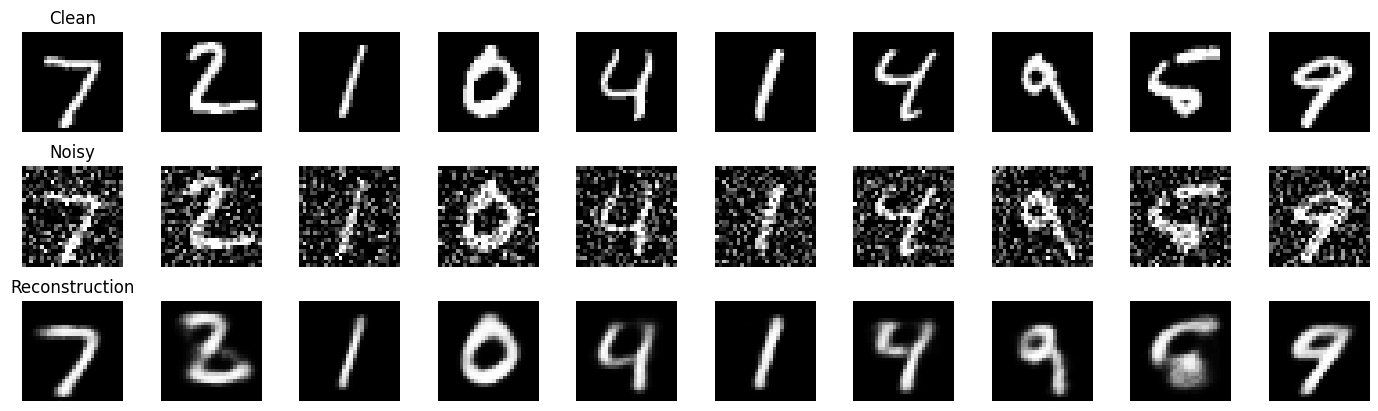

In [18]:
@torch.no_grad()
def show_denoising_examples(model, loader, sigma=0.35, n=10):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)

    x_noisy = add_noise(x, sigma=sigma)
    x_hat = model(x_noisy)

    x = x.cpu()
    x_noisy = x_noisy.cpu()
    x_hat = x_hat.cpu()

    fig, axes = plt.subplots(3, n, figsize=(1.4*n, 4.2))
    for i in range(n):
        axes[0, i].imshow(x[i, 0], cmap="gray"); axes[0, i].axis("off")
        axes[1, i].imshow(x_noisy[i, 0], cmap="gray"); axes[1, i].axis("off")
        axes[2, i].imshow(x_hat[i, 0], cmap="gray"); axes[2, i].axis("off")

    axes[0, 0].set_title("Clean")
    axes[1, 0].set_title("Noisy")
    axes[2, 0].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

show_denoising_examples(model, test_loader, sigma=sigma, n=10)


## 7) Extract Latent Codes

We collect encoder outputs \(z\) and labels to visualize structure in the latent space.


In [8]:
@torch.no_grad()
def collect_latents(model, loader, max_items=5000):
    model.eval()
    Z_list, y_list = [], []
    count = 0

    for x, y in loader:
        x = x.to(device)
        z = model.encoder(x)
        Z_list.append(z.cpu().numpy())
        y_list.append(y.numpy())
        count += x.size(0)
        if count >= max_items:
            break

    Z = np.concatenate(Z_list, axis=0)[:max_items]
    y = np.concatenate(y_list, axis=0)[:max_items]
    return Z, y

Z, y = collect_latents(model, test_loader, max_items=5000)
Z.shape, y.shape


((5000, 16), (5000,))

## 8) PCA Plot (Latent Space)


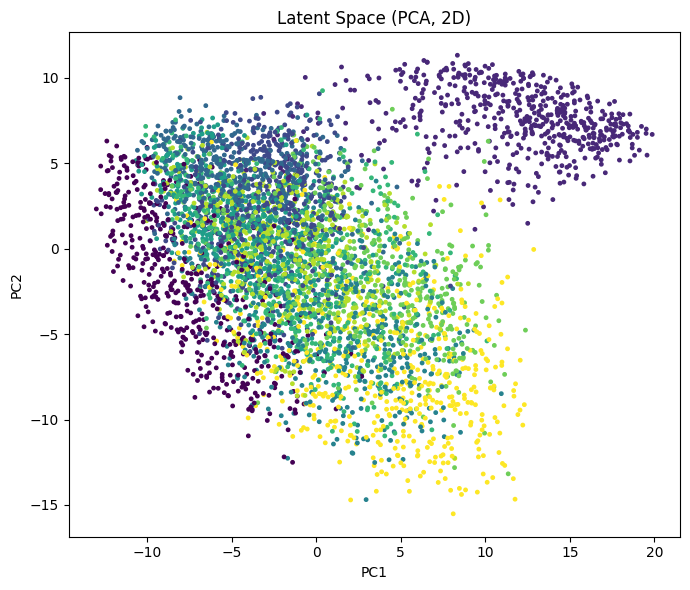

In [20]:
Z_pca = PCA(n_components=2, random_state=0).fit_transform(Z)

plt.figure(figsize=(7, 6))
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=y, s=6)
plt.title("Latent Space (PCA, 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## 9) t-SNE Plot (Latent Space)

t-SNE is non-linear and often shows clusters more clearly. It is slower than PCA, so we use a subset.


In [ ]:
n_tsne = min(3000, Z.shape[0])
Z_tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0).fit_transform(Z[:n_tsne])
y_tsne = y[:n_tsne]

plt.figure(figsize=(7, 6))
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=y_tsne, s=6)
plt.title("Latent Space (t-SNE, 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


## 10) Visualizing the Decoder (Manifold via PCA Directions)

To “show the decoder part”, we decode a grid of latent points.

Because the latent space is 16D, we build a 2D grid in the **first two PCA directions** of the latent codes:
\[
z \approx \mu + u_1\alpha + u_2\beta
\]
and decode each \(z\) into an image.


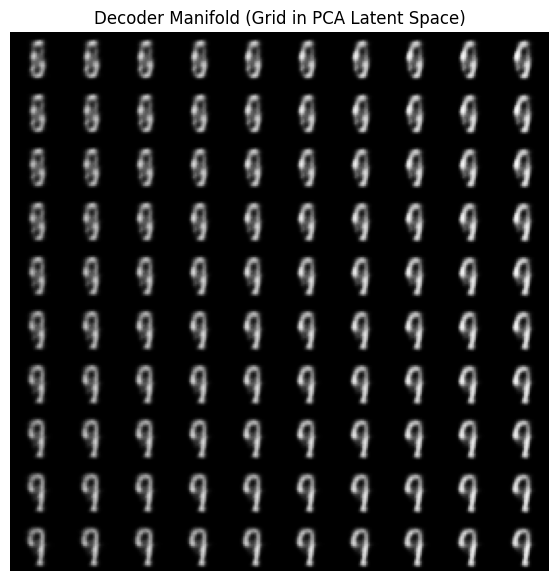

In [9]:
@torch.no_grad()
def decoder_manifold_via_pca(model, Z, grid=10, span=2.5):
    model.eval()

    pca = PCA(n_components=2, random_state=0)
    pca.fit(Z)

    mu = Z.mean(axis=0)          # (latent_dim,)
    U = pca.components_          # (2, latent_dim)

    xs = np.linspace(-span, span, grid)
    ys = np.linspace(-span, span, grid)

    rows = []
    for yv in ys[::-1]:
        cols = []
        for xv in xs:
            z = mu + U[0] * xv + U[1] * yv
            z_t = torch.tensor(z, dtype=torch.float32, device=device).unsqueeze(0)
            x_hat = model.decoder(z_t).squeeze(0).detach().cpu().numpy()[0]  # (28,28)
            cols.append(x_hat)
        rows.append(np.concatenate(cols, axis=1))

    canvas = np.concatenate(rows, axis=0)

    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap="gray")
    plt.axis("off")
    plt.title("Decoder Manifold (Grid in PCA Latent Space)")
    plt.show()

decoder_manifold_via_pca(model, Z, grid=10, span=2.5)
